## Labels
Labels are composed of 3 parts:
* class (there are 13 possible classes) - 13 values
* bounding box predicted by the (i,j) cell - 4 values (c1,c2), w, h

In [57]:
import os
import pandas as pd
import random as rand
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#TODO Convert labels from the original format of the dataset to (x1,x2,y1,y2,class). We are interested in annotation['item1']['bounding_box'] and annotation['item1']['category_id']. Note there can be more than one item per image
#TODO Convert labels from (x1,x2,y1,y2,class) to (c1,c2,height,width,confidence,class) 
#        (confidence is the IoU between the bounding box of the prediction and the bounding box of the ground truth, in the labels it must be set to one)
class DataLoader:
    annotations = {}
    images = []
    random_shuffling_for_file_indexes = []
    
    
    def __init__(self, number_of_samples, images_folder, annotations_folder, normalize=True, randomize=True):
        self.number_of_samples = number_of_samples
        self.images_folder = images_folder
        self.annotations_folder = annotations_folder
        if randomize:
            self._random_shuffling()
        self.images = self.load_n_images()
        self.annotations = self.load_n_annotations()
        if normalize:
            self.normalize_image()
    
    #use the same shuffling for both images and annotations
    def _random_shuffling(self):
        self.random_shuffling_for_file_indexes = [i for i in range(0, len(self.get_file_names_in_directory(self.images_folder)))]
        rand.shuffle(self.random_shuffling_for_file_indexes)

    def get_file_names_in_directory(self,directory_path):
        res = []
        for path in os.listdir(directory_path):
            # check if current path is a file
            if os.path.isfile(os.path.join(directory_path, path)):
                res.append(path)
        return res

    def load_n_annotations(self):
        annotation = []
        counter = 0
        file_names = self.get_file_names_in_directory(self.annotations_folder)
        for i in range(0, self.number_of_samples):
            clear_output(wait=True)
            annotation.append(pd.read_json(os.path.join(self.annotations_folder, file_names[self.random_shuffling_for_file_indexes[i]])))
            counter = counter + 1
            print(str(counter / self.number_of_samples * 100.0) + " %")
        return annotation

    
    def load_n_images(self):
        images = []
        counter = 0
        images_names = self.get_file_names_in_directory(self.images_folder)
        for i in range(0, self.number_of_samples):
            clear_output(wait=True)
            images.append(mpimg.imread(os.path.join(self.images_folder, images_names[self.random_shuffling_for_file_indexes[i]])))
            counter = counter + 1
            print(str(counter / self.number_of_samples * 100.0) + " %")
        return images
    
    def normalize_image(self):
        for i in range(0, len(self.images)):
            self.images[i] = self.images[i] / 255

In [58]:
images_train_folder_path = "../Object-Detection-Deep-Fashion/Data/train/images/"
annotations_train_folder_path = "../Object-Detection-Deep-Fashion/Data/train/annotations/"
images_test_folder_path = "../Object-Detection-Deep-Fashion/Data/test/images/"
annotations_test_folder_path = "../Object-Detection-Deep-Fashion/Data/test/annotations/"

# images_train_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/train/images"
# annotations_train_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/train/annotations"
# images_test_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/test/images"
# annotations_test_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/test/annotations"

In [59]:
def get_file_names_in_directory(directory_path):
        res = []
        for path in os.listdir(directory_path):
            # check if current path is a file
            if os.path.isfile(os.path.join(directory_path, path)):
                res.append(path)
        return res

In [90]:
dataset_1000_examples = DataLoader(number_of_samples = 1000,
               images_folder = images_train_folder_path,
               annotations_folder = annotations_train_folder_path)

100.0 %


In [61]:
assert len(dataset_1000_examples.images) == 1000
assert len(dataset_1000_examples.annotations) == 1000

In [91]:
def cleanup_annotations(dataset):
    for annotation in dataset.annotations:
        annotation.drop(labels=["source", "pair_id"], axis="columns", inplace=True)
        annotation.drop(labels=["segmentation", "scale", "viewpoint", "zoom_in", "landmarks", "style", "occlusion"], axis="index", inplace=True)

def convert_annotations(dataset):
    for i, annotation in enumerate(dataset.annotations):
        newItems = []
        columns = []
        for (itemID, itemData) in annotation.items():
            boundingbox = itemData["bounding_box"]
            center = [boundingbox[0]+(boundingbox[2]/2), boundingbox[1]+(boundingbox[3]/2)]
            size = [boundingbox[2], boundingbox[3]]
            confidence = 1
            
            newItem = [center, size, confidence, itemData["category_id"], itemData["category_name"]]
            newItems.append(newItem)
            columns.append(itemID)
        dataset.annotations[i] = pd.DataFrame(data=newItems, index=columns, columns=["center", "size", "confidence", "category_id", "category_name"]).T

In [92]:
#Plot an annotation
cleanup_annotations(dataset_1000_examples)
convert_annotations(dataset_1000_examples)

In [93]:

dataset_1000_examples.annotations[245]

,item1
center,"[214.5, 233.0]"
size,"[180, 463]"
confidence,1
category_id,10
category_name,short sleeve dress


### Check the number of Labels - 13 labels

In [15]:
def count_labels(dataset):
    category_ids_already_found = []
    for i in range(0, len(dataset.annotations)):
        actualCategoryId = dataset.annotations[i]["item1"]["category_id"]
        if(not(actualCategoryId in category_ids_already_found)):
            category_ids_already_found.append(actualCategoryId)
    return category_ids_already_found

In [18]:
#test "count the number of categories. There should be 13"
assert len(count_labels(dataset_1000_examples)) == 13

12


AssertionError: 

### Draw a box from a training sample to see what the json label represents

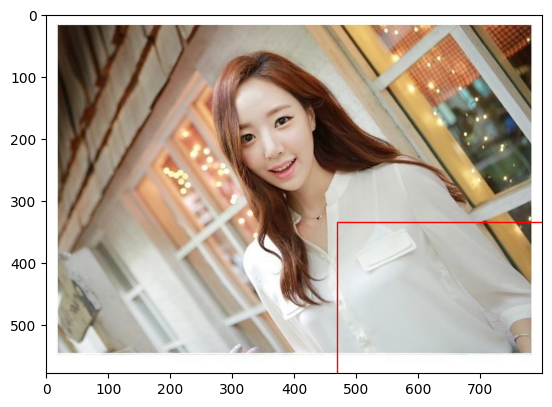

In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

#bounding_box_sample_1 = dataset_1000_examples.annotations[0]["item1"]["bounding_box"]
bounding_box_center = dataset_1000_examples.annotations[3]["item1"]["center"]
bounding_box_size = dataset_1000_examples.annotations[3]["item1"]["size"]
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(dataset_1000_examples.images[3])

# Create a Rectangle patch
#rect1 = patches.Rectangle((bounding_box_sample_1[0], bounding_box_sample_1[1]), bounding_box_sample_1[2], bounding_box_sample_1[3], linewidth=1, edgecolor='r', facecolor='none')
rect1 = patches.Rectangle((bounding_box_center[0] - bounding_box_size[0]/2, bounding_box_center[1] - bounding_box_size[1]/2), bounding_box_size[0], bounding_box_size[1], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)

plt.show()

## Data we are going to use
We are going to use category and bounding box data, out objective is object detection, hence we will ignore data about segmentation, localization, etc.

## Preprocess
We are going to squash the data into a [0,1] range with normalization for the dataset (faster learning). Before normalization we will apply some data augmentation.
(move this above, we did normalization in the DataLoader class)

In [ ]:
#4) load resnet pretrained model

In [ ]:
#5) build the architecture

In [ ]:
#6) implement metrics, training cycle, backprop

In [ ]:
#7) evaluate model on test set

In [ ]:
#8) show some results